In [83]:
from processing.database import Database
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [84]:
db = Database('../data/database.db')
cmt = db.query('SELECT * FROM comments')

In [85]:
print(cmt.info(verbose = True))
print(cmt.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   num_sentences     100000 non-null  int64 
 1   edited            100000 non-null  int64 
 2   removal_type      100000 non-null  int64 
 3   collapsed         100000 non-null  int64 
 4   distinguished     100000 non-null  int64 
 5   subreddit_type    100000 non-null  int64 
 6   author            100000 non-null  object
 7   body              100000 non-null  object
 8   created_utc       100000 non-null  int64 
 9   archived          100000 non-null  int64 
 10  controversiality  100000 non-null  int64 
 11  id                100000 non-null  object
 12  link_id           100000 non-null  object
 13  locked            100000 non-null  int64 
 14  is_submitter      100000 non-null  int64 
 15  parent_id         100000 non-null  object
 16  score             100000 non-null  int6

In [86]:
out = cmt.describe().transpose()
out[out['std'] == 0].transpose() # std == 0 means that these are likely useless

,edited
count,100000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


count    100000.000000
mean          2.404100
std           3.294552
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         186.000000
Name: num_sentences, dtype: float64


<Axes: >

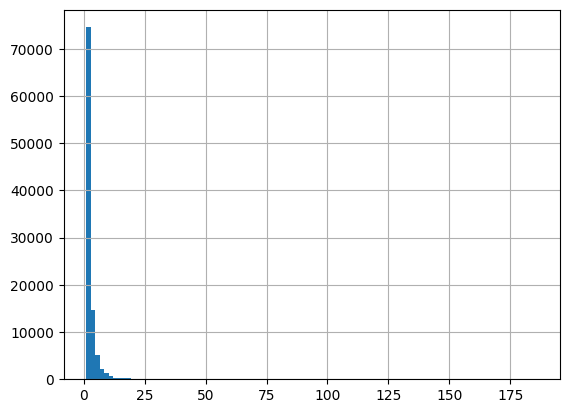

In [87]:
print(cmt['num_sentences'].describe())
cmt['num_sentences'].hist(bins = 100)

In [88]:
(cmt[cmt['num_sentences'] >= 3]['num_sentences']).count() / cmt['num_sentences'].count()

np.float64(0.25431)

In [89]:
v = cmt[cmt['score'] == cmt['score'].min()]
print(v)
print(v['permalink'].values[0])

       num_sentences  edited  removal_type  collapsed  distinguished  \
56553              2       0             0          0              0   

       subreddit_type           author  \
56553               0  Speederbear9422   

                                                    body  created_utc  \
56553  Thats not physically possible unless she was i...   1751328418   

       archived  controversiality       id     link_id  locked  is_submitter  \
56553         0                 0  n0o8aix  t3_1lon1ld       0             0   

        parent_id  score subreddit_id          subreddit  stickied  \
56553  t3_1lon1ld   -474     t5_30tmh  TwoSentenceHorror         0   

                                               permalink  
56553  /r/TwoSentenceHorror/comments/1lon1ld/the_poli...  
/r/TwoSentenceHorror/comments/1lon1ld/the_police_found_my_missing_daughters_dress_in/n0o8aix/


In [90]:
cmt[cmt['controversiality'] == cmt['controversiality'].max()]['permalink'].values[0]

'/r/MurderedByWords/comments/1lomi26/choosing_beggar_takedown/n0o72ov/'

In [91]:
v = cmt[cmt['num_sentences'] == cmt['num_sentences'].max()]
v['permalink'].values[0]

'/r/Calgary/comments/1ln4cip/gender_reveal_and_then_litter_in_bowness_park/n0o90ul/'

In [92]:
print(cmt['distinguished'].value_counts())
print(cmt[cmt['author'] != 'AutoModerator']['distinguished'].value_counts())

print(cmt[cmt['distinguished'] == 2])

distinguished
0    96240
1     3760
Name: count, dtype: int64
distinguished
0    96240
1      733
Name: count, dtype: int64
Empty DataFrame
Columns: [num_sentences, edited, removal_type, collapsed, distinguished, subreddit_type, author, body, created_utc, archived, controversiality, id, link_id, locked, is_submitter, parent_id, score, subreddit_id, subreddit, stickied, permalink]
Index: []


In [93]:
import stanza
import simpletransformers.classification as cl
import re

p = stanza.Pipeline(lang="en", processors="tokenize")

count = len(cmt['body'])

buf_docid = []
buf_id = []
buf_text = []

for n in range(count):
    if n % 10_000 == 0:
        print(f'\rCompletion = {n / count}', end='')

    if cmt['num_sentences'][n] < 3:
        continue
    
    # note that this gets rid of punctuation
    sentenceDelimiter = re.compile(r'((?:\.|\?|!|\S$)(?:\s|$))', flags = re.MULTILINE)

    one_text = [x.strip() for x in re.split(sentenceDelimiter, cmt['body'][n])]
    if not one_text[-1]:
        del one_text[-1]

    if len(one_text) % 2 == 1:
        raise Exception

    c = int(len(one_text) / 2)
    for t in range(c):
        buf_docid.append(n + 1)
        buf_id.append(t + 1)
        buf_text.append(one_text[2 * t] + one_text[2 * t + 1])

sentences_final = pd.DataFrame({
    'doc_id': buf_docid,
    'id': buf_id,
    'text': buf_text
})

buf_docid = []
buf_id = []
buf_text = []



2025-10-04 19:38:40 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-10-04 19:38:40 INFO: Downloaded file to C:\Users\andallfor\stanza_resources\resources.json
2025-10-04 19:38:40 WARNING: Language en package default expects mwt, which has been added
2025-10-04 19:38:40 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

2025-10-04 19:38:40 INFO: Using device: cpu
2025-10-04 19:38:40 INFO: Loading: tokenize
2025-10-04 19:38:40 INFO: Loading: mwt
2025-10-04 19:38:40 INFO: Done loading processors!


Completion = 0.9

In [98]:
# Wrangle extracted sentences into sentence trigrams
u_docs = sentences_final["doc_id"].unique()

buf_tri = []
buf_docid = []
buf_id = []

cp = sentences_final['doc_id']
tt = sentences_final['text']

jj = len(cp)

count = len(u_docs)
j = 0
for n in range(count):
    if n % 10_000 == 0:
        print(f'\rCompletion = {n / count}', end='')

    doc_id = u_docs[n]
    text = []
    while j < jj and cp[j] == doc_id:
        text.append(tt[j])
        j += 1

    if len(text) < 3:
        sentence_trigram = [' '.join(text)]
    else:
        # create trigrams
        sentence_trigram = []
        for i in range(len(text) - 2):
            sentence_trigram.append(text[i] + ' ' + text[i + 1] + ' ' + text[i + 2])

    for i in range(len(sentence_trigram)):
        buf_tri.append(sentence_trigram[i])
        buf_id.append(i + 1)
        buf_docid.append(doc_id)

# concatenate all the new data into a final DataFrame
final = pd.DataFrame({
    'sent_trigram': buf_tri,
    'id': buf_id,
    'doc_id': buf_docid,
})

buf_tri = []
buf_docid = []
buf_id = []

Completion = 0.78644174432778895

In [101]:
print(f"Number of comments: {len(u_docs)}")
print(f'Number of trigrams: {len(final['sent_trigram'])}')

Number of comments: 25431
Number of trigrams: 94176


In [103]:
# Load authdetect model and predict (don't use multiprocessing for larger text since it causes stalling)
model = cl.ClassificationModel("roberta",
                               "mmochtak/authdetect", 
                               args={"use_multiprocessing_for_evaluation": True,},
                               use_cuda=False
                               )

# Annotate the prepared trigrams with the authdetect model.
prediction = model.predict(to_predict = final["sent_trigram"].tolist())

anno_df = final.assign(predict = prediction[1])

scores = prediction[1] if isinstance(prediction, tuple) and len(prediction) >= 2 else prediction

anno_df_speech = anno_df.groupby('doc_id').agg(
    demo=('predict', lambda x: x.mean()),
    auth=('predict', lambda x: 1 - x.mean()),
    auth_sent=('predict', lambda x: (x <= 0.5).mean()),
    num_sent=('predict', lambda x: x.size),
    predict_std=('predict', lambda x: x.std(ddof=0)),
).reset_index()

189it [01:12,  2.62it/s]                         
Predicting: 100%|██████████| 942/942 [2:25:16<00:00,  9.25s/it]  


<Axes: >

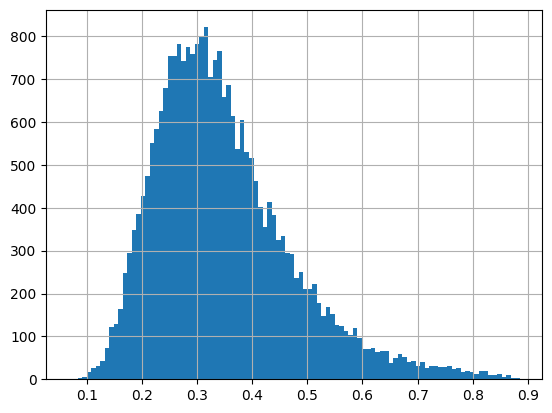

In [104]:
anno_df_speech['auth'].hist(bins=100)

In [134]:
dd = []
for i in range(len(anno_df_speech['doc_id'])):
    doc_id = int(anno_df_speech['doc_id'][i])
    row = cmt.loc[doc_id - 1, :]
    dd.append(row['id'])

anno_df_speech = anno_df_speech.assign(cmt_id = dd)


In [135]:
import sqlite3

out = {
    'anno_df.db': anno_df,
    'anno_df_speech.db': anno_df_speech
}

for file, data in out.items():
    open(file, 'w').close()
    con = sqlite3.connect(file)
    data.to_sql('main', con)

In [140]:
print(anno_df_speech.describe())
m = anno_df_speech['auth'].max()
v = anno_df_speech[anno_df_speech['auth'] == m]
print(v)
most = cmt[cmt['id'] == v['cmt_id'].values[0]]
most['permalink'].values[0]

             doc_id          demo          auth     auth_sent      num_sent  \
count  25431.000000  25431.000000  25431.000000  25431.000000  25431.000000   
mean   50005.606386      0.652021      0.347979      0.133679      3.703197   
std    28996.542979      0.125004      0.125004      0.293252      5.243605   
min        1.000000      0.115170      0.067089      0.000000      1.000000   
25%    24780.500000      0.588456      0.259382      0.000000      1.000000   
50%    50026.000000      0.673541      0.326459      0.000000      2.000000   
75%    75004.000000      0.740618      0.411544      0.000000      4.000000   
max    99996.000000      0.932911      0.884830      1.000000    184.000000   

        predict_std  
count  25431.000000  
mean       0.038484  
std        0.047764  
min        0.000000  
25%        0.000000  
50%        0.021162  
75%        0.062102  
max        0.337913  
      doc_id     demo     auth  auth_sent  num_sent  predict_std   cmt_id
1155    4548  0.

'/r/Foodforthought/comments/1kja9ay/young_men_are_leading_a_religious_resurgence/n0o767p/'